In [1]:
# Step 1: Import necessary libraries
# Note: You may need to install some if not present: pip install pandas numpy matplotlib seaborn wordcloud vaderSentiment googletrans==4.0.0-rc1 (for translation)
import pandas as pd
import re
from googletrans import Translator  # For translating Arabic to English
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

# Initialize translator
translator = Translator()

In [3]:
# Step 2: Load the data
# Replace 'tweet_market_impact_new.xlsx' with your actual file path
df = pd.read_excel('/Users/myronkneip/Documents/Githubbackup/tweet_market_impact_new.xlsx')

# Display initial shape and head for inspection
print("Initial Data Shape:", df.shape)
df.head()

Initial Data Shape: (11854, 32)


,tweet_ID,Timestamp,Twitter_acc,Tweet,Mid_Open_Execution,Execution_Delayed,MI_1min_MidOpen,MI_1min_MidClose,MI_5min_MidOpen,MI_5min_MidClose,...,MI_12h_MidOpen,MI_12h_MidClose,MI_1d_MidOpen,MI_1d_MidClose,MI_2d_MidOpen,MI_2d_MidClose,MI_3d_MidOpen,MI_3d_MidClose,MI_4d_MidOpen,MI_4d_MidClose
0,12635,2025-06-21 19:52:00,TrumpDailyPosts,Donald J. Trump Truth Social 06.21.25 03:21 PM...,75.07,True,39.296656,39.962701,NaN,NaN,...,-121.88624,-113.227654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10724,2025-06-21 19:47:00,TrumpDailyPosts,Donald J. Trump Truth Social 06.21.25 03:21 PM...,75.07,True,39.296656,39.962701,NaN,NaN,...,-121.88624,-113.227654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,982,2025-06-21 18:35:00,TrumpDailyPosts,TAKE POLL,75.07,True,39.296656,39.962701,NaN,NaN,...,-121.88624,-113.227654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12425,2025-06-21 18:25:00,TrumpDailyPosts,TAKE POLL,75.07,True,39.296656,39.962701,NaN,NaN,...,-121.88624,-113.227654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4099,2025-06-21 18:06:00,TrumpDailyPosts,Donald J. Trump Truth Social 06.20.25 06:34 PM...,75.07,True,39.296656,39.962701,NaN,NaN,...,-121.88624,-113.227654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Fresh Start: Reload the data without any filtering or additions
import pandas as pd

# Load the Excel file, specifying sheet and header
df = pd.read_excel('tweet_market_impact_new.xlsx', sheet_name='Sheet1', header=0)

# Print initial shape and columns to verify
print("Initial Data Shape:", df.shape)
print("Columns:", df.columns.tolist())

# If shape is not (11854, 32), check for skipped rows or data issues
# Optionally, use skiprows=0 or usecols=range(32) if format issues
# df = pd.read_excel('tweet_market_impact_new.xlsx', sheet_name='Sheet1', header=0, usecols=range(32))

# Proceed with minimal processing, no filtering yet
# For Execution_Delayed, just flag without removing
if 'Execution_Delayed' in df.columns:
    df['is_delayed'] = df['Execution_Delayed'].astype(bool)  # Ensure bool

print("Shape before any dropna or filter:", df.shape)

# To keep all rows for now, don't dropna; handle NaNs in analysis (e.g., mean MI ignoring NaNs)
# If you must drop for target, do it later in analysis cells

Initial Data Shape: (11854, 32)
Columns: ['tweet_ID', 'Timestamp', 'Twitter_acc', 'Tweet', 'Mid_Open_Execution', 'Execution_Delayed', 'MI_1min_MidOpen', 'MI_1min_MidClose', 'MI_5min_MidOpen', 'MI_5min_MidClose', 'MI_15min_MidOpen', 'MI_15min_MidClose', 'MI_30min_MidOpen', 'MI_30min_MidClose', 'MI_1h_MidOpen', 'MI_1h_MidClose', 'MI_2h_MidOpen', 'MI_2h_MidClose', 'MI_4h_MidOpen', 'MI_4h_MidClose', 'MI_8h_MidOpen', 'MI_8h_MidClose', 'MI_12h_MidOpen', 'MI_12h_MidClose', 'MI_1d_MidOpen', 'MI_1d_MidClose', 'MI_2d_MidOpen', 'MI_2d_MidClose', 'MI_3d_MidOpen', 'MI_3d_MidClose', 'MI_4d_MidOpen', 'MI_4d_MidClose']
Shape before any dropna or filter: (11854, 33)


In [12]:
# Modified Step 3: Don't filter, but flag and adjust timestamps
# No removal: df = df[df['Execution_Delayed'] == False]  # Comment out or remove this line

# Add flag (if not already)
df['is_delayed'] = df['Execution_Delayed']  # Or .astype(bool) if needed

# Shift timestamps for delayed tweets to next Monday (simplified: add 2 days for Sat, 1 for Sun)
def shift_to_monday(ts, is_delayed):
    if is_delayed:
        dow = ts.weekday()
        if dow == 5:  # Saturday
            return ts + pd.Timedelta(days=2)
        elif dow == 6:  # Sunday
            return ts + pd.Timedelta(days=1)
    return ts

df['adjusted_timestamp'] = df.apply(lambda row: shift_to_monday(row['Timestamp'], row['is_delayed']), axis=1)

print("Shape with all tweets (including delayed):", df.shape)
df[['Timestamp', 'adjusted_timestamp', 'is_delayed']].head(10)  # Inspect

Shape with all tweets (including delayed): (11854, 34)


,Timestamp,adjusted_timestamp,is_delayed
0,2025-06-21 19:52:00,2025-06-23 19:52:00,True
1,2025-06-21 19:47:00,2025-06-23 19:47:00,True
2,2025-06-21 18:35:00,2025-06-23 18:35:00,True
3,2025-06-21 18:25:00,2025-06-23 18:25:00,True
4,2025-06-21 18:06:00,2025-06-23 18:06:00,True
5,2025-06-21 18:03:00,2025-06-23 18:03:00,True
6,2025-06-21 17:57:00,2025-06-23 17:57:00,True
7,2025-06-21 17:53:00,2025-06-23 17:53:00,True
8,2025-06-21 16:12:00,2025-06-23 16:12:00,True
9,2025-06-21 14:42:00,2025-06-23 14:42:00,True


In [13]:
# Check missing values in MI columns to choose a better target
mi_columns = [col for col in df.columns if col.startswith('MI_') and 'MidOpen' in col]  # Focus on MidOpen for example
missing_counts = df[mi_columns].isna().sum().sort_values()
print("Missing Values in MI Columns (sorted least to most):")
print(missing_counts)

# Optionally, select the MI column with fewest NaNs as target
# For example, if MI_1min_MidOpen has fewer NaNs:
target_col = missing_counts.index[0]  # Auto-select the one with least missing
print(f"Selected Target with Least Missing: {target_col}")

# Drop NaNs only for the selected target (to maximize rows)
df = df.dropna(subset=[target_col])

print("New Shape after minimal dropna:", df.shape)

# Alternative: Impute missing in other columns if needed later (but skip for now to keep minimal)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='median')
# df[mi_columns] = imputer.fit_transform(df[mi_columns])

Missing Values in MI Columns (sorted least to most):
MI_30min_MidOpen     79
MI_2h_MidOpen        97
MI_4h_MidOpen        99
MI_12h_MidOpen      107
MI_8h_MidOpen       120
MI_1h_MidOpen       129
MI_1d_MidOpen       194
MI_15min_MidOpen    196
MI_1min_MidOpen     245
MI_4d_MidOpen       273
MI_5min_MidOpen     275
MI_2d_MidOpen       401
MI_3d_MidOpen       441
dtype: int64
Selected Target with Least Missing: MI_30min_MidOpen
New Shape after minimal dropna: (11775, 34)


In [16]:
# Enhanced Step 4: Multi-language detection and translation
# Install if needed: !pip install langdetect deep-translator
from langdetect import detect, LangDetectException
from deep_translator import GoogleTranslator
import re
from time import sleep  # Add this for retry delay

# Function to detect language (returns 'ar' for Arabic, 'fa' for Persian, 'ur' for Urdu, etc.)
def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except LangDetectException:
        return None  # If detection fails

# Update is_non_english to use Arabic-script check as fallback, but we'll use detection
def is_non_english(text):
    return bool(re.search(r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF]', text))  # Broader Arabic-script range for Persian/Urdu too

df['is_non_english'] = df['Tweet'].apply(is_non_english)

# Translate function with language detection, Hebrew mapping, and retry
def translate_to_english_multi(text):
    if is_non_english(text):
        src_lang = detect_language(text)
        if src_lang is None or src_lang == 'en':
            return text  # Skip if English or undetectable
        
        # Map 'he' to 'iw' for Hebrew
        if src_lang == 'he':
            src_lang = 'iw'
        
        for attempt in range(3):
            try:
                translated = GoogleTranslator(source=src_lang, target='en').translate(text)
                return translated
            except Exception as e:
                print(f"Translation error for lang '{src_lang}' (attempt {attempt+1}): {e}")
                sleep(2)
        return text  # Fallback
    return text

# Apply translation
df['Tweet_translated'] = df['Tweet'].apply(translate_to_english_multi)

# Add detected language column for inspection
df['detected_lang'] = df['Tweet'].apply(detect_language)

# Display samples of non-English tweets with translations and detected lang
non_english_sample = df[df['is_non_english'] & (df['detected_lang'] != 'en')].head(20)
print("Sample Translated Non-English Tweets:")
print(non_english_sample[['Tweet', 'detected_lang', 'Tweet_translated']])

# Optional: Filter and print Persian/Urdu specifically
persian_urdu = df[df['detected_lang'].isin(['fa', 'ur'])].head(10)
print("\nPersian/Urdu Samples:")
print(persian_urdu[['Tweet', 'detected_lang', 'Tweet_translated']])

Sample Translated Non-English Tweets:
                                                  Tweet detected_lang  \
1079                                  يَا مَنصُور أَمِت            ar   
1084  بازوی رسمی سازمان اطلاعات سپاه در پیام‌رسان «ب...            fa   
1539               چگونه خانه های تیمی را شناسایی کنیم.            fa   
1880  وسائل إعلام إسرائيلية:\n\n⭕ "الجيش" يدعو السكا...            ar   
1929                                 آپ کا شکریہ، بھائی            ur   
2166                #معركة_الفتح_الموعود_والجهاد_المقدس            ar   
2496  Remember their names:  \n🔸 Amir Ali Amini (17,...            fa   
2639  در صورت مشاهده هرگونه فعالیت مشکوک یا تردد خود...            fa   
2749  نخست‌وزیر بنیامین نتانیاهو با مردم ایران صحبت ...            fa   
2780        نَصْرٌ مِّن اللَّهِ وَفَتْحٌ قَرِيبٌ 🇵🇸🇾🇪🇮🇷            ar   
2788              نَصْرٌ مِنَ اللَّهِ وَ فَتْحٌ قَرِيبٌ            ar   
2867  ارتكب الكيان الصهيوني خطًأ فادحًا، واقترف حماق...            ar   
2918  رَبَّنَ

In [17]:
df.head()

,tweet_ID,Timestamp,Twitter_acc,Tweet,Mid_Open_Execution,Execution_Delayed,MI_1min_MidOpen,MI_1min_MidClose,MI_5min_MidOpen,MI_5min_MidClose,...,MI_2d_MidClose,MI_3d_MidOpen,MI_3d_MidClose,MI_4d_MidOpen,MI_4d_MidClose,is_delayed,adjusted_timestamp,is_non_english,Tweet_translated,detected_lang
0,12635,2025-06-21 19:52:00,TrumpDailyPosts,Donald J. Trump Truth Social 06.21.25 03:21 PM...,75.07,True,39.296656,39.962701,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,2025-06-23 19:52:00,False,Donald J. Trump Truth Social 06.21.25 03:21 PM...,en
1,10724,2025-06-21 19:47:00,TrumpDailyPosts,Donald J. Trump Truth Social 06.21.25 03:21 PM...,75.07,True,39.296656,39.962701,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,2025-06-23 19:47:00,False,Donald J. Trump Truth Social 06.21.25 03:21 PM...,en
2,982,2025-06-21 18:35:00,TrumpDailyPosts,TAKE POLL,75.07,True,39.296656,39.962701,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,2025-06-23 18:35:00,False,TAKE POLL,vi
3,12425,2025-06-21 18:25:00,TrumpDailyPosts,TAKE POLL,75.07,True,39.296656,39.962701,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,2025-06-23 18:25:00,False,TAKE POLL,vi
4,4099,2025-06-21 18:06:00,TrumpDailyPosts,Donald J. Trump Truth Social 06.20.25 06:34 PM...,75.07,True,39.296656,39.962701,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,2025-06-23 18:06:00,False,Donald J. Trump Truth Social 06.20.25 06:34 PM...,en


In [18]:
# Step 5: Remove links from translated tweets
# Use regex to strip URLs
df['Tweet_clean'] = df['Tweet_translated'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x).strip())

# Display sample cleaned tweets
print("Sample Cleaned Tweets (no links):")
print(df[['Tweet_translated', 'Tweet_clean']].head(20))  # Show more to include non-English

Sample Cleaned Tweets (no links):
                                     Tweet_translated  \
0   Donald J. Trump Truth Social 06.21.25 03:21 PM...   
1   Donald J. Trump Truth Social 06.21.25 03:21 PM...   
2                                           TAKE POLL   
3                                           TAKE POLL   
4   Donald J. Trump Truth Social 06.20.25 06:34 PM...   
5   Donald J. Trump Truth Social 06.20.25 05:58 PM...   
6   Donald J. Trump Truth Social 06.20.25 05:58 PM...   
7   Donald J. Trump Truth Social 06.20.25 05:58 PM...   
8                      President Trump News Community   
9   Donald J. Trump Truth Social 06.20.25 04:38 PM...   
10  Donald J. Trump Truth Social 06.20.25 03:40 PM...   
11  Donald J. Trump Truth Social 06.20.25 09:34 AM...   
12  Donald J. Trump Truth Social 06.20.25 09:34 AM...   
13                     President Trump News Community   
14  Donald J. Trump Truth Social 06.20.25 06:34 PM...   
15  Donald J. Trump Truth Social 06.20.25 06:34 PM... 

In [21]:
# Setup: Define targets and prepare DF
target_cols = [
    'MI_1min_MidOpen',
    'MI_5min_MidOpen',
    'MI_15min_MidOpen'
]

# No global dropna; we'll handle per analysis


=== Analysis 1 for MI_1min_MidOpen ===
Shape: (11593, 38)
Top Words:
Iran         0.161515
ballistic    0.150009
Iranian      0.133726
Israel       0.120259
Tehran       0.115711
earlier      0.114527
missiles     0.102163
missile      0.092762
zerohedge    0.090909
Israeli      0.086073
attack       0.037620
States       0.027841
military     0.022180
regime       0.021001
United       0.019287
Donald       0.017392
06           0.017119
IDF          0.014722
com          0.014373
Social       0.013440
Name: MI_1min_MidOpen, dtype: float64
Bottom Words:
Hamas       -0.033106
year        -0.033744
IEA         -0.034325
Prime       -0.034609
Minister    -0.034829
2025        -0.035019
bloomberg   -0.035232
Gaza        -0.036002
org         -0.036211
market      -0.038173
Energy      -0.039166
power       -0.041344
global      -0.041370
security    -0.041736
energy      -0.047557
OPEC        -0.048227
new         -0.048869
Yemeni      -0.052496
li          -0.055992
iea         -0.05622

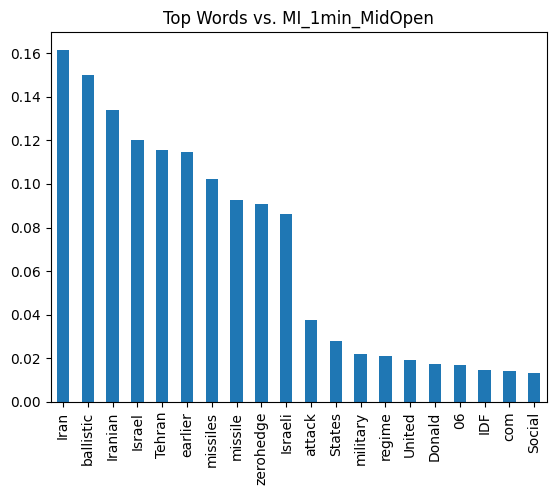

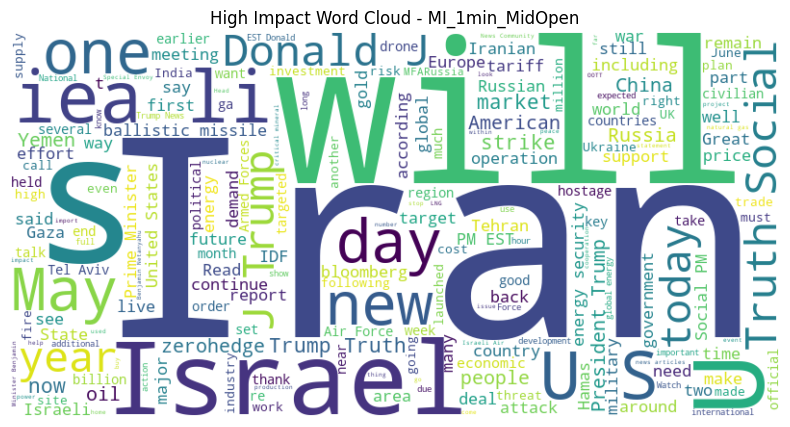


=== Analysis 1 for MI_5min_MidOpen ===
Shape: (11565, 38)
Top Words:
Iran         0.145425
ballistic    0.132678
Iranian      0.119757
Tehran       0.107962
Israel       0.103448
earlier      0.101712
missiles     0.092852
zerohedge    0.082207
missile      0.078936
Israeli      0.070019
attack       0.030373
Donald       0.025526
Social       0.024303
EST          0.023227
Truth        0.022879
06           0.020767
United       0.019920
regime       0.019430
military     0.019328
IDF          0.015949
Name: MI_5min_MidOpen, dtype: float64
Bottom Words:
bloomberg   -0.031109
year        -0.031231
said        -0.031501
years       -0.031572
Netanyahu   -0.031936
Hamas       -0.032265
war         -0.033580
org         -0.033643
global      -0.034042
market      -0.034933
Gaza        -0.037290
Energy      -0.037421
security    -0.037836
energy      -0.039470
power       -0.041560
OPEC        -0.044679
new         -0.048545
li          -0.050926
iea         -0.051030
Yemeni      -0.05468

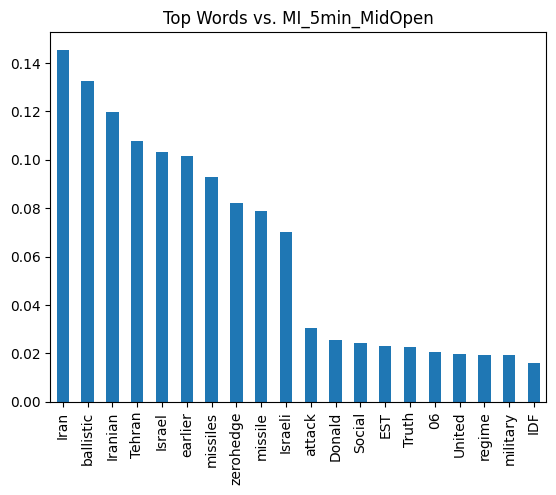

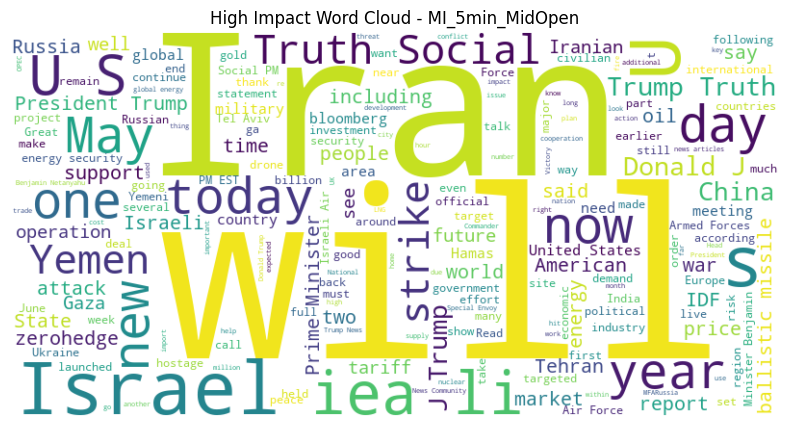


=== Analysis 1 for MI_15min_MidOpen ===
Shape: (11647, 38)
Top Words:
Iran         0.128387
ballistic    0.113020
Iranian      0.111283
Tehran       0.096067
Israel       0.095725
earlier      0.091367
missiles     0.081307
zerohedge    0.069533
missile      0.060010
Israeli      0.057820
Social       0.049134
EST          0.048809
Truth        0.047495
Donald       0.046951
06           0.037621
25           0.035986
States       0.031791
attack       0.028775
United       0.024868
05           0.024752
Name: MI_15min_MidOpen, dtype: float64
Bottom Words:
just        -0.026699
year        -0.027892
years       -0.028146
bloomberg   -0.028284
org         -0.030037
Prime       -0.030207
prices      -0.030498
market      -0.032891
Netanyahu   -0.033654
energy      -0.034845
security    -0.035424
Gaza        -0.035541
power       -0.037408
war         -0.037676
Energy      -0.038663
OPEC        -0.039973
new         -0.042728
iea         -0.051203
li          -0.051208
Yemeni      -0.061

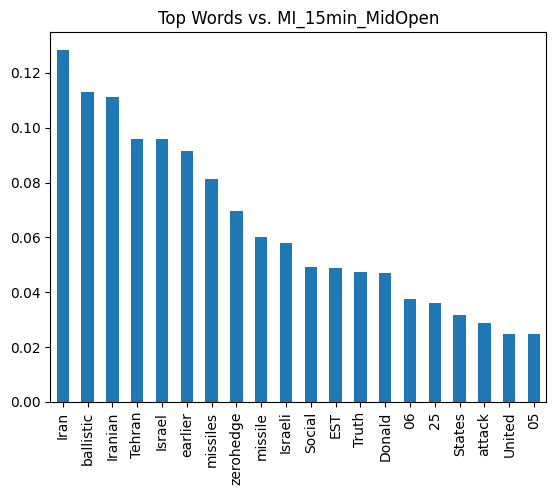

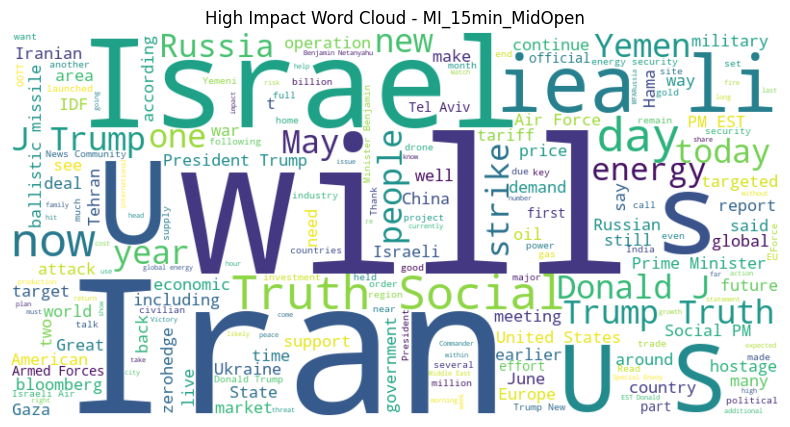

In [22]:
# Analysis 1: Which words cause market impact in general (loop over targets)
for target_col in target_cols:
    print(f"\n=== Analysis 1 for {target_col} ===")
    
    analysis_df = df.dropna(subset=[target_col])
    print("Shape:", analysis_df.shape)
    
    vectorizer = CountVectorizer(lowercase=False, stop_words='english', binary=True, max_features=100)
    word_matrix = vectorizer.fit_transform(analysis_df['Tweet_clean'])
    words_df = pd.DataFrame(word_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    
    combined = pd.concat([words_df, analysis_df[target_col].reset_index(drop=True)], axis=1)
    
    word_corrs = combined.corr()[target_col].drop(target_col).sort_values(ascending=False)
    
    print("Top Words:")
    print(word_corrs.head(20))
    print("Bottom Words:")
    print(word_corrs.tail(20))
    
    word_corrs.head(20).plot(kind='bar', title=f'Top Words vs. {target_col}')
    plt.show()
    
    # Word cloud
    median_impact = analysis_df[target_col].median()
    high_text = ' '.join(analysis_df[analysis_df[target_col] > median_impact]['Tweet_clean'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(high_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'High Impact Word Cloud - {target_col}')
    plt.show()

In [23]:
# Import necessary libraries (if not already)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame from previous steps
# Select all MI columns (Open and Close variants)
mi_columns = [col for col in df.columns if col.startswith('MI_') and ('MidOpen' in col or 'MidClose' in col)]

# Group by Twitter_acc and compute averages for positive, negative, and absolute MI
# We'll create separate DFs for positive, negative, and abs averages

# Helper function to compute means
def compute_mi_averages(grouped):
    # Positive: mean where >0
    pos_avg = grouped[mi_columns].apply(lambda x: x[x > 0].mean())
    # Negative: mean where <0 (note: means will be negative)
    neg_avg = grouped[mi_columns].apply(lambda x: x[x < 0].mean())
    # Absolute: mean of abs values for overall impact magnitude
    abs_avg = grouped[mi_columns].apply(lambda x: x.abs().mean())
    return pos_avg, neg_avg, abs_avg

# Group by account
grouped = df.groupby('Twitter_acc')

# Compute the averages
pos_matrix, neg_matrix, abs_matrix = compute_mi_averages(grouped)

# Transpose for matrix format: Accounts on rows (X-axis in table), MI columns on columns (Y-axis in table)
pos_matrix = pos_matrix.transpose()
neg_matrix = neg_matrix.transpose()
abs_matrix = abs_matrix.transpose()

# Display the matrices as tables
print("\nAverage Positive Market Impact (Upward Movement):")
display(pos_matrix)  # Use display for nicer Jupyter output

print("\nAverage Negative Market Impact (Downward Movement):")
display(neg_matrix)

print("\nAverage Absolute Market Impact (Overall Magnitude):")
display(abs_matrix)


Average Positive Market Impact (Upward Movement):


Twitter_acc,BurggrabenH,IDF,IEA,IRIran_Military,IntelDoge,IsraeliPM,JavierBlas,OPECSecretariat,OSE_Yemen,OilSheppard,POTUS,SStapczynski,TrumpDailyPosts,WhiteHouse,Yemenimilitary,chigrl,mfa_russia,realDonaldTrump,sentdefender,zerohedge
MI_1min_MidOpen,35.206691,76.954543,12.488662,53.773476,71.950501,42.239638,27.212062,19.803788,15.532597,14.567135,290.731130,29.879108,64.223163,136.318868,81.396373,42.006629,40.915997,26.141700,250.519241,135.642277
MI_1min_MidClose,38.346181,80.437022,15.415820,56.772701,73.657142,41.409551,28.989812,23.399821,19.697003,16.796181,320.804665,33.202985,73.866377,136.540325,81.362472,42.702153,44.603675,32.641380,235.880790,139.369465
MI_5min_MidOpen,32.605836,58.013787,16.883713,45.855632,56.309781,34.420131,26.020755,20.386586,22.423112,15.352896,243.563706,25.236558,55.904585,92.264519,61.195204,35.327655,36.179687,30.087381,167.521237,98.380898
MI_5min_MidClose,32.251851,52.090797,17.827902,44.124072,54.299027,32.065080,26.775891,20.260690,21.627208,13.986248,219.886204,25.234938,57.461979,89.450420,58.162626,34.612952,37.835325,25.368348,159.599236,96.043670
MI_15min_MidOpen,43.984416,51.245495,27.138476,47.060476,59.304179,32.677079,31.706548,27.224560,25.836719,17.777331,177.871366,28.156921,66.061722,84.225264,59.133733,39.883981,39.824274,38.739655,142.223382,88.716050
MI_15min_MidClose,44.731656,52.084818,27.556718,48.596936,60.014486,33.608303,33.255595,27.620732,27.873990,18.628650,168.760543,28.876234,68.106590,85.554759,59.694538,40.121177,40.247044,42.713018,141.791839,87.722671
MI_30min_MidOpen,44.947611,54.082839,31.750234,52.312552,73.615612,35.419917,43.840421,32.142520,34.642426,27.485702,188.255675,34.245049,82.947577,84.284543,58.306360,42.915604,44.544172,29.690858,139.655557,90.298873
MI_30min_MidClose,45.946147,53.023802,31.761193,54.840541,73.990899,37.159260,43.585000,32.966133,34.572522,28.260371,191.070322,34.846968,73.535519,88.300029,59.382629,43.791474,47.194976,27.904115,144.088693,93.420810
MI_1h_MidOpen,53.550058,55.027944,40.746046,55.277535,92.916956,42.586569,51.851487,39.636350,36.627557,36.525560,161.355215,42.008099,68.732858,85.608374,61.529512,50.060836,51.677610,25.680122,122.763137,95.514151
MI_1h_MidClose,53.004120,55.446592,42.127146,57.126351,93.986663,43.556935,52.654979,40.134461,37.407042,34.634728,164.271328,41.348063,70.138015,88.439618,62.749717,51.699317,52.731350,22.076590,123.162105,93.808802



Average Negative Market Impact (Downward Movement):


Twitter_acc,BurggrabenH,IDF,IEA,IRIran_Military,IntelDoge,IsraeliPM,JavierBlas,OPECSecretariat,OSE_Yemen,OilSheppard,POTUS,SStapczynski,TrumpDailyPosts,WhiteHouse,Yemenimilitary,chigrl,mfa_russia,realDonaldTrump,sentdefender,zerohedge
MI_1min_MidOpen,-29.121085,-21.882023,-23.328440,-38.743616,-20.180979,-41.774230,-25.871770,-18.340297,-32.641245,-18.215801,-11.664850,-12.492969,-8.646836,-5.943739,-40.011828,-39.714812,-5.915707,-17.726705,-8.536648,-9.570942
MI_1min_MidClose,-31.078289,-25.559403,-25.140193,-40.157389,-23.749522,-44.937863,-27.346534,-20.272720,-30.281590,-20.294597,-13.599611,-14.062021,-9.713076,-8.480547,-43.238658,-39.358465,-7.587630,-18.248864,-12.533518,-11.520630
MI_5min_MidOpen,-34.559151,-27.849530,-28.421810,-39.095056,-30.224973,-49.339320,-31.465167,-24.173955,-32.526665,-23.630197,-14.808840,-19.659668,-13.490234,-13.845304,-51.189294,-38.948731,-12.128764,-22.256657,-18.016222,-17.722040
MI_5min_MidClose,-36.367914,-31.830566,-28.637548,-42.261414,-32.408090,-58.768059,-31.937926,-26.250536,-34.507791,-26.356191,-19.271621,-20.058044,-14.946358,-14.764019,-53.407428,-39.489851,-13.258034,-27.514277,-20.755016,-19.313939
MI_15min_MidOpen,-40.786195,-37.396139,-33.258973,-51.222635,-38.164334,-71.520113,-41.291294,-31.917790,-48.224279,-28.444714,-26.915121,-25.950355,-21.188658,-23.735069,-54.333435,-48.291834,-22.983667,-24.874570,-32.865585,-31.056595
MI_15min_MidClose,-42.044591,-37.308264,-33.825935,-50.608711,-39.177899,-69.953746,-41.407508,-33.087381,-46.201701,-27.511563,-28.030889,-27.327659,-21.399197,-25.285536,-54.507796,-48.406191,-23.820707,-25.004100,-35.474901,-33.994139
MI_30min_MidOpen,-49.953352,-44.333993,-42.039324,-54.606399,-48.808056,-79.187482,-48.839650,-39.084701,-45.072176,-33.825479,-25.191584,-35.158281,-24.590430,-32.224492,-62.955717,-52.373599,-27.839088,-31.878259,-42.917488,-48.736305
MI_30min_MidClose,-50.272152,-46.406373,-42.550335,-54.283610,-49.908283,-75.430880,-50.721618,-38.919417,-45.805707,-35.560523,-24.697006,-34.979962,-24.482837,-31.576523,-64.793557,-52.043707,-26.542999,-35.211756,-42.737130,-50.312145
MI_1h_MidOpen,-60.808351,-55.058292,-52.838472,-64.032720,-59.465522,-74.959728,-67.033974,-49.345722,-58.090690,-44.187517,-43.024969,-47.802560,-34.398140,-49.494024,-75.499093,-61.970029,-38.002399,-42.199887,-59.173562,-64.974644
MI_1h_MidClose,-61.215637,-54.811613,-51.899854,-63.473470,-60.368982,-79.190352,-68.108115,-50.466169,-58.353701,-44.644039,-39.669966,-48.276422,-34.574676,-48.700009,-75.853621,-61.933599,-39.040503,-41.795853,-59.065574,-68.827908



Average Absolute Market Impact (Overall Magnitude):


Twitter_acc,BurggrabenH,IDF,IEA,IRIran_Military,IntelDoge,IsraeliPM,JavierBlas,OPECSecretariat,OSE_Yemen,OilSheppard,POTUS,SStapczynski,TrumpDailyPosts,WhiteHouse,Yemenimilitary,chigrl,mfa_russia,realDonaldTrump,sentdefender,zerohedge
MI_1min_MidOpen,30.094757,45.350633,15.876983,43.682033,45.363366,39.524910,24.338783,17.697902,21.410596,14.743831,201.171047,18.165504,35.743430,80.856979,56.348269,36.669065,22.195360,18.751925,167.854240,81.737841
MI_1min_MidClose,33.430598,49.635412,18.510041,46.080972,49.261228,41.774255,27.040194,20.374801,25.080220,17.503968,203.151666,20.523193,41.020420,82.541737,59.714477,38.643920,25.224920,23.525286,169.200865,83.690834
MI_5min_MidOpen,32.369616,42.089861,21.634879,40.844202,44.666398,42.509293,27.482385,21.788736,26.644423,18.893959,141.039003,21.307729,35.097700,60.983622,53.792348,35.826631,24.034185,25.065544,120.820780,64.480148
MI_5min_MidClose,33.315112,41.793205,22.483825,41.792496,45.014480,44.074496,28.290714,22.554494,26.472698,19.156296,138.376658,21.670518,36.189867,60.078969,54.066264,36.202678,25.186280,25.154916,118.439105,64.320664
MI_15min_MidOpen,41.863441,44.681738,29.901122,47.793623,51.201348,47.170998,35.537961,29.137900,33.875992,22.227311,122.697509,26.672815,47.166116,59.850930,55.568178,42.749230,32.435796,30.756727,109.542650,67.151468
MI_15min_MidClose,42.836784,44.793533,30.516823,48.571500,51.962142,47.820230,36.650078,29.506050,34.563299,22.504481,120.852576,27.465722,47.309032,59.689291,55.882482,42.958854,32.861755,32.516974,110.280236,67.892089
MI_30min_MidOpen,46.837486,49.665330,36.367988,52.714589,64.464233,51.622681,45.758849,35.053225,38.899453,30.407961,125.805598,34.084878,58.678636,65.473831,60.227255,46.501299,37.880123,30.768235,112.970922,76.116876
MI_30min_MidClose,47.395831,49.882244,36.686580,53.631792,65.054197,52.368907,46.342293,35.444980,39.975149,30.550599,127.352882,34.449915,53.399614,67.061945,61.145900,47.520022,38.510769,30.144894,116.586373,78.380175
MI_1h_MidOpen,56.108236,54.461356,46.080046,58.522452,81.559988,58.213151,58.882594,43.814944,44.527366,38.984581,118.554913,44.062303,55.647918,70.968288,67.952759,55.278383,46.349618,33.300612,106.461707,83.044954
MI_1h_MidClose,56.337033,54.619316,46.369764,58.923955,81.769499,58.057296,59.983070,44.531052,45.286975,38.559479,116.551658,44.041721,56.779051,70.937049,69.037100,55.930518,47.223957,31.637444,106.731462,84.073897


In [24]:
# Export the matrices to an Excel file with multiple sheets
with pd.ExcelWriter('mi_impact_matrices.xlsx') as writer:
    pos_matrix.to_excel(writer, sheet_name='Positive_MI')
    neg_matrix.to_excel(writer, sheet_name='Negative_MI')
    abs_matrix.to_excel(writer, sheet_name='Absolute_MI')

print("Matrices exported to 'mi_impact_matrices.xlsx'")

Matrices exported to 'mi_impact_matrices.xlsx'


In [25]:
# Setup: Imports and key configurations
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  # For TF-IDF in windows
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import pearsonr  # For correlations in windows

# Assume df is loaded and processed (translated, cleaned) from previous steps
# Sort by timestamp for feed-like processing
df = df.sort_values('adjusted_timestamp').reset_index(drop=True)

# Define key words to weight higher
key_words = ['explosions', 'Tehran', 'WTI', 'Israel', 'Netanyahu', 'nuclear', 'Trump', 'strike', 'missile']

# Define market opening windows (UTC times; adjust for CL Futures if needed)
# Asian: ~00:00 UTC, European: ~08:00 UTC, US: ~13:30 UTC
def get_market_session(hour):
    if 0 <= hour < 8:
        return 'Asian'
    elif 8 <= hour < 13:
        return 'European'
    elif 13 <= hour < 22:
        return 'US'
    else:
        return 'After-Hours'

df['hour'] = df['adjusted_timestamp'].dt.hour
df['market_session'] = df['hour'].apply(get_market_session)

# Compute MI differences: Close - Open for each interval
intervals = ['1min', '5min', '15min', '30min', '1h', '2h', '4h', '8h', '12h', '1d', '2d', '3d', '4d']
for interval in intervals:
    open_col = f'MI_{interval}_MidOpen'
    close_col = f'MI_{interval}_MidClose'
    if open_col in df.columns and close_col in df.columns:
        df[f'MI_{interval}_Diff'] = df[close_col] - df[open_col]

# New target diffs (focus on these for analysis)
target_diffs = [f'MI_{interval}_Diff' for interval in intervals if f'MI_{interval}_Diff' in df.columns]

# Baseline: Use MI_1min_MidOpen as starting point, compute diffs to later
df['MI_Baseline'] = df['MI_1min_MidOpen']  # Starting point
for interval in intervals[1:]:  # From 5min onward
    open_col = f'MI_{interval}_MidOpen'
    if open_col in df.columns:
        df[f'MI_{interval}_FromBaseline'] = df[open_col] - df['MI_Baseline']

In [34]:
# MI diffs: Close - Open
intervals = ['1min', '5min', '15min', '30min', '1h', '2h', '4h', '8h', '12h', '1d', '2d', '3d', '4d']
for interval in intervals:
    open_col = f'MI_{interval}_MidOpen'
    close_col = f'MI_{interval}_MidClose'
    if open_col in df.columns and close_col in df.columns:
        df[f'MI_{interval}_Diff'] = df[close_col] - df[open_col]

# Baseline diffs: From 1min Open to later Open
df['MI_Baseline'] = df['MI_1min_MidOpen']
for interval in intervals[1:]:
    open_col = f'MI_{interval}_MidOpen'
    if open_col in df.columns:
        df[f'MI_{interval}_FromBaseline'] = df[open_col] - df['MI_Baseline']

# Feed-style windowing
window_size = '1H'
df['window'] = df['adjusted_timestamp'].dt.floor(window_size)

key_words = ['explosions', 'Tehran', 'WTI', 'Israel', 'Netanyahu', 'nuclear', 'Trump', 'strike', 'missile']

# Function to detect topic surges and novelty (with empty text handling)
def analyze_window(group):
    text = ' '.join(group['Tweet_clean'])
    unique_accounts = group['Twitter_acc'].nunique()
    
    if not text.strip():  # Handle empty or whitespace-only text
        return pd.Series({'topic_count': 0, 'unique_accounts': unique_accounts, 
                          'novelty_score': 0, 'key_word_weight': 0})
    
    # TF-IDF for topics (higher for emerging)
    vectorizer = TfidfVectorizer(lowercase=False, stop_words='english', max_features=50, min_df=1)
    try:
        tfidf = vectorizer.fit_transform([text])
        topics = vectorizer.get_feature_names_out()
    except ValueError:  # Catch empty vocabulary error
        return pd.Series({'topic_count': 0, 'unique_accounts': unique_accounts, 
                          'novelty_score': 0, 'key_word_weight': 0})
    
    # Novelty: Simple inverse freq (global approximation)
    global_freq = df['Tweet_clean'].str.contains('|'.join(topics), case=True).mean()
    novelty = 1 - global_freq if global_freq > 0 else 1
    
    # Key word weight (boost by multi-account)
    key_count = sum(text.count(word) for word in key_words)
    key_weight = key_count * unique_accounts
    
    return pd.Series({'topic_count': len(topics), 'unique_accounts': unique_accounts, 
                      'novelty_score': novelty, 'key_word_weight': key_weight})

# Apply to groups
window_insights = df.groupby('window').apply(analyze_window).reset_index()

# Merge back to DF
df = df.merge(window_insights, on='window', how='left')

# Filter high-conviction windows: Multi-account, high novelty/key weight
high_conviction = df[(df['unique_accounts'] > 1) & (df['key_word_weight'] > 0) & (df['novelty_score'] > 0.5)]
print("High Conviction Tweets Shape:", high_conviction.shape)

print("Data Processing Complete. Shape:", df.shape)

/var/folders/3w/l_jvhqms4kl086z6gkrqpq1c0000gn/T/ipykernel_44272/4042783329.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['window'] = df['adjusted_timestamp'].dt.floor(window_size)


High Conviction Tweets Shape: (1008, 79)
Data Processing Complete. Shape: (11775, 79)


/var/folders/3w/l_jvhqms4kl086z6gkrqpq1c0000gn/T/ipykernel_44272/4042783329.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  window_insights = df.groupby('window').apply(analyze_window).reset_index()


Sample MI Impact Matrix (First 20 Tweets):


,tweet_ID,Twitter_acc,adjusted_timestamp,Tweet_clean,market_session,MI_5min_FromBaseline,MI_15min_FromBaseline,MI_30min_FromBaseline,MI_1h_FromBaseline,MI_2h_FromBaseline,MI_4h_FromBaseline,MI_8h_FromBaseline,MI_12h_FromBaseline,MI_1d_FromBaseline,MI_2d_FromBaseline,MI_3d_FromBaseline,MI_4d_FromBaseline
24,1413,SStapczynski,2024-12-11 13:08:00,The front page of Japan’s top business newspap...,US,4.323701,18.736038,5.044318,5.044318,25.942207,83.591554,141.240902,145.564603,135.475967,141.961519,272.393169,272.393169
25,7510,IDF,2024-12-11 13:45:00,"🔴Fehmi Salmi, a Nukhba Company Commander and S...",US,-5.034160,-10.068321,-5.034160,-22.294139,-51.060770,69.759079,110.032362,98.525710,105.717368,143.113988,250.988853,250.988853
60,7963,IDF,2024-12-12 17:03:00,With the direction of IDF and ISA intelligence...,US,-2.857755,61.441738,38.579696,47.152961,14.288776,10.002143,-20.004287,5.715510,155.747660,168.607559,168.607559,65.728370
61,13833,OPECSecretariat,2024-12-12 17:33:00,#EnergyAccess #WaterSupply,US,-7.107826,-4.264695,2.132348,-0.710783,-33.406781,-47.622432,-56.151823,-49.043997,122.254602,122.965385,122.965385,78.896865
86,7105,SStapczynski,2024-12-16 15:41:00,A pair of gas-fired power plants in the UK ear...,US,-14.068655,-21.102983,-2.110298,-8.441193,-15.475521,-30.951041,-38.688801,-89.335959,-76.674170,-128.728194,-146.314012,-272.931908
87,8515,IDF,2024-12-16 15:41:00,"🇮🇱🤝🇺🇸\n\nThe Commander of @CENTCOM, GEN Michae...",US,-14.068655,-21.102983,-2.110298,-8.441193,-15.475521,-30.951041,-38.688801,-89.335959,-76.674170,-128.728194,-146.314012,-272.931908
122,14748,OPECSecretariat,2024-12-19 09:10:00,#Oil #EnergyAvailability,European,10.633773,-2.835673,14.887282,4.253509,9.924855,2.126755,-58.131292,-181.483057,-240.323267,-155.962002,-155.962002,-108.464483
123,5978,IDF,2024-12-19 09:15:00,🚨A recent report claims Israel deliberately us...,European,0.000000,-3.541829,1.416732,2.833463,0.000000,-2.833463,-68.711483,-188.425303,-253.594956,-162.924134,-162.924134,-98.462846
165,8376,OPECSecretariat,2024-12-23 16:01:00,#Oil #Modernliving,US,1.437608,4.312823,6.469235,15.813686,24.439333,56.066705,43.128235,-33.064980,0.718804,113.571018,113.571018,24.439333
166,7373,IDF,2024-12-23 16:11:00,Watch to understand the history between Israel...,US,0.000000,-23.230490,-18.874773,-26.134301,30.490018,82.758621,85.662432,78.402904,184.392015,201.814882,172.776770,207.622505


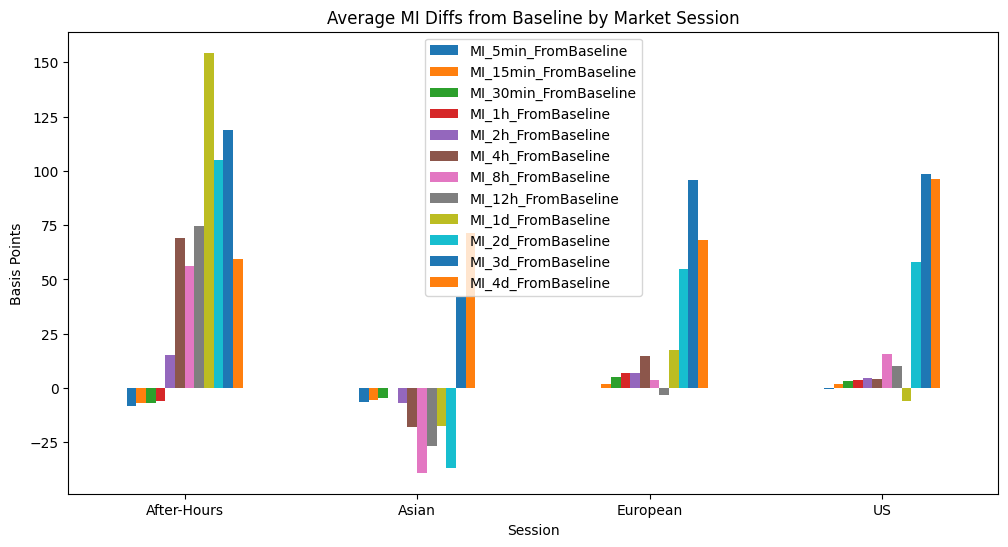

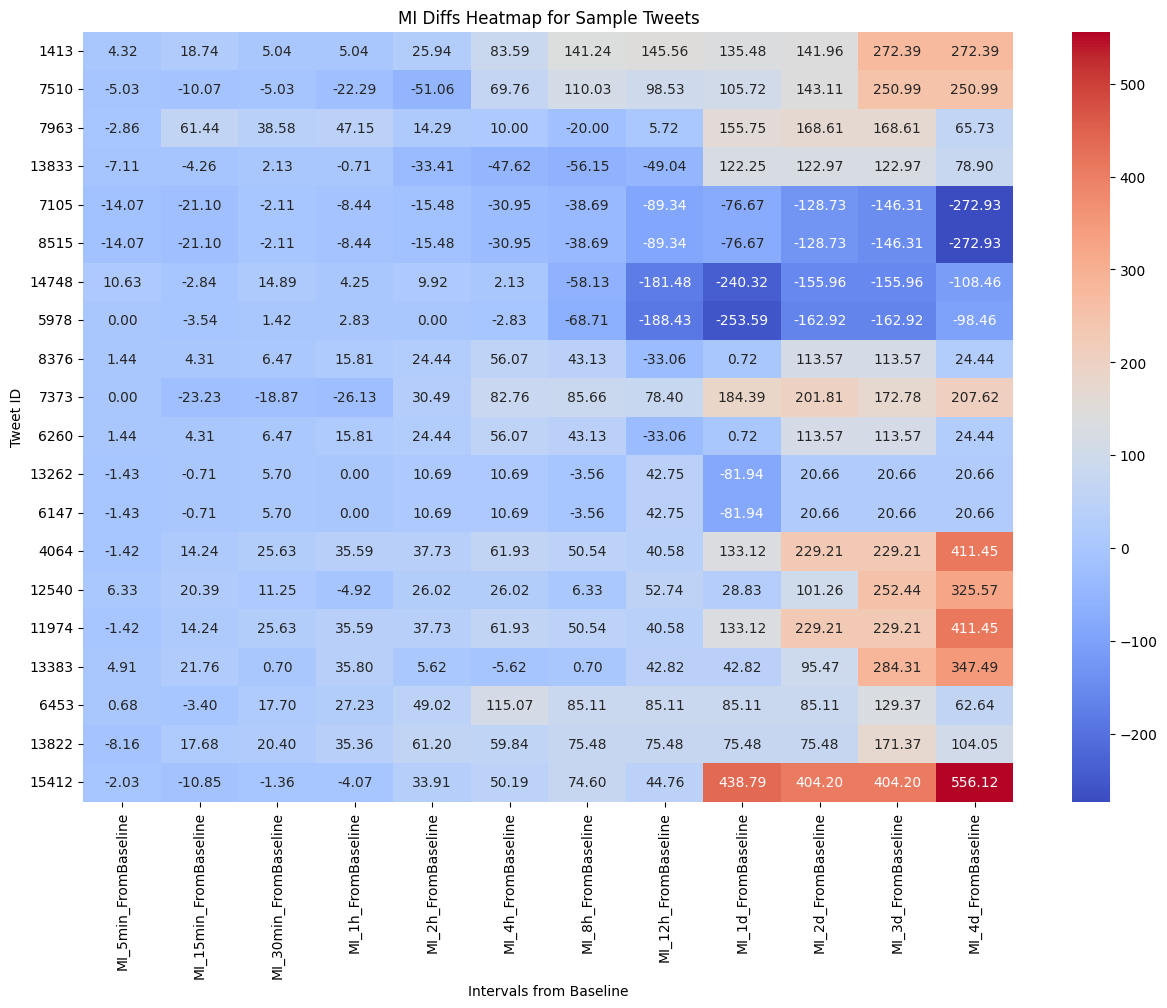

In [35]:
# New Analysis: Market Impact by Tweet in Basis Points (Diffs from Baseline)
# Create a matrix: Rows = Tweets (with ID, Account, Timestamp, Clean Text), Columns = Diffs across intervals

# Select relevant columns for matrix
tweet_info = df[['tweet_ID', 'Twitter_acc', 'adjusted_timestamp', 'Tweet_clean', 'market_session']]
diff_cols = [f'MI_{interval}_FromBaseline' for interval in intervals[1:] if f'MI_{interval}_FromBaseline' in df.columns]

# Concat to form matrix
mi_matrix = pd.concat([tweet_info, df[diff_cols]], axis=1)

# Filter to high-conviction for focus (optional; remove if full DF wanted)
mi_matrix = mi_matrix[mi_matrix['tweet_ID'].isin(high_conviction['tweet_ID'])]

# Sort by timestamp for feed view
mi_matrix = mi_matrix.sort_values('adjusted_timestamp')

# Display top N rows (e.g., 50) for inspection; full in Excel below
print("Sample MI Impact Matrix (First 20 Tweets):")
display(mi_matrix.head(20))

# Visualize average diffs by session
avg_diffs_session = mi_matrix.groupby('market_session')[diff_cols].mean()
avg_diffs_session.plot(kind='bar', figsize=(12, 6))
plt.title('Average MI Diffs from Baseline by Market Session')
plt.ylabel('Basis Points')
plt.xlabel('Session')
plt.xticks(rotation=0)
plt.show()

# Heatmap for matrix sample (top 20 tweets)
plt.figure(figsize=(15, 10))
sns.heatmap(mi_matrix[diff_cols].head(20), annot=True, cmap='coolwarm', fmt='.2f', yticklabels=mi_matrix['tweet_ID'].head(20))
plt.title('MI Diffs Heatmap for Sample Tweets')
plt.xlabel('Intervals from Baseline')
plt.ylabel('Tweet ID')
plt.show()

In [ ]:
# Export full MI matrix to Excel for better viewing
mi_matrix.to_excel('tweet_mi_impact_matrix.xlsx', index=False)
print("Full MI Impact Matrix exported to 'tweet_mi_impact_matrix.xlsx'")

In [ ]:
# Trade Feasibility: For each interval, stats on diffs (mean, std, min/max) to assess early/late entry
feasibility_stats = pd.DataFrame(index=diff_cols)
feasibility_stats['Mean Diff'] = mi_matrix[diff_cols].mean()
feasibility_stats['Std Dev'] = mi_matrix[diff_cols].std()
feasibility_stats['Min Diff'] = mi_matrix[diff_cols].min()
feasibility_stats['Max Diff'] = mi_matrix[diff_cols].max()
feasibility_stats['Positive %'] = (mi_matrix[diff_cols] > 0).mean() * 100

print("Trade Feasibility Stats (Diffs from Baseline):")
display(feasibility_stats)

# Plot mean diffs over intervals
feasibility_stats['Mean Diff'].plot(kind='line', marker='o', title='Average MI Change Over Time from Baseline')
plt.ylabel('Basis Points')
plt.xlabel('Interval')
plt.grid(True)
plt.show()

In [ ]:
# Save the processed dataframe for further use
df.to_csv('processed_tweets.csv', index=False)
print("Processed data saved to 'processed_tweets.csv'")

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time

# === Configuration ===
MAX_TWEETS = 100

# List of Twitter handles (without '@')
accounts = [
    #"OPECSecretariat",
    #"IEA",
    #"KremlinRussia_E",
    #"mfa_russia",
    #"WhiteHouse",
    #"POTUS",
    #"IsraeliPM",
    #"IDF",
    #"IRIran_Military",
    #"JavierBlas",
    #"OilSheppard",
    #"DanielYergin",
    #"SStapczynski",
    #"zerohedge",
    #"chigrl",
    #"BurggrabenH",
    #"sentdefender",
    #"IntelDoge",
    #"TrumpDailyPosts",
    #"Yemenimilitary",
    #"OSE_Yemen",
   
]

def setup_driver():
    options = Options()
    options.add_argument("--headless=new")  # Better headless mode
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--disable-gpu")
    options.add_argument("window-size=1200x900")
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.5735.90 Safari/537.36")
    
    driver = webdriver.Chrome(options=options)
    driver.set_window_size(1200, 900)
    return driver

def scrape_tweets(driver, username, max_tweets=100):
    url = f"https://nitter.poast.org/{username}"
    #url = f"https://nitter.tiekoetter.com/{username}"
    driver.get(url)
    time.sleep(2)

    collected = []
    seen = set()

    while len(collected) < max_tweets:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        try:
            load_more = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, "//div[@class='show-more']/a"))
            )
            driver.execute_script("arguments[0].click();", load_more)
            print("🔁 Clicked 'Load more'")
            time.sleep(2)
        except Exception:
            print("❌ 'Load more' button not found or no longer clickable.")
            break

        soup = BeautifulSoup(driver.page_source, "html.parser")
        tweets = soup.find_all("div", class_="timeline-item")

        for tweet in tweets:
            text_tag = tweet.find("div", class_="tweet-content")
            time_tag = tweet.find("span", class_="tweet-date")
            if not text_tag or not time_tag:
                continue

            content = text_tag.text.strip()
            timestamp_a = time_tag.find("a")
            timestamp = timestamp_a.get("title", "N/A") if timestamp_a else "N/A"

            tweet_id = f"{timestamp}-{content}"
            if tweet_id not in seen:
                collected.append([timestamp, content])
                seen.add(tweet_id)

            if len(collected) >= max_tweets:
                break

    return collected

def save_to_excel(tweets, username):
    df = pd.DataFrame(tweets, columns=["Timestamp", "Tweet"])
    filename = f"{username}_tweets.xlsx"
    df.to_excel(filename, index=False)
    print(f"\n✅ Saved {len(tweets)} tweets to {filename}")

if __name__ == "__main__":
    driver = setup_driver()
    try:
        for username in accounts:
            print(f"\n🌐 Scraping @{username}...")
            tweets = scrape_tweets(driver, username, max_tweets=MAX_TWEETS)
            if tweets:
                save_to_excel(tweets, username)
    finally:
        driver.quit()
        
print("Downloading complete. All tweets saved to Excel files.")